Conduct RFM (recency, frequency, monetary value) analysis on political donors in the UK

In [146]:
#imports
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt


# DATA PROCESSING

In [147]:
#read data
df = pd.read_csv('data/Donations accepted by political parties.csv')
df.shape

/var/folders/9t/ywq9gg3s4zbgn2zw5tfskbv00000gn/T/ipykernel_23597/3107819911.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Donations accepted by political parties.csv')


(65278, 29)

In [148]:

#drop all nans from the columns that we will be using
df = df.dropna(subset=['Value', 'DonorId', 'ReceivedDate'])
df.shape

(62492, 29)

In [149]:
#change received data from string to datetime
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y')

#Change monetary value to float for computation
df['Value'] = df['Value'].replace('[\£,]', '', regex=True).astype(float)



Text(0, 0.5, 'Frequency')

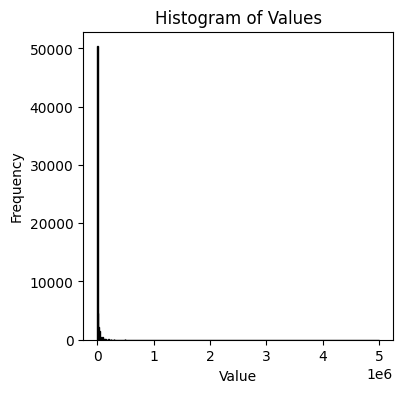

In [150]:
#Hist plots of columns to understand distribution
plt.figure(figsize=(4, 4))  # Optional: specify the figure size
df['Value'].plot(kind='hist', bins=500, edgecolor='black')

plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')


In [151]:
#There are extereme outliers which will affect the results of our RFM analysis. Therefore we can use the IQR method to remove the outliers.
#Outlers are able Q3 + 1.5*IQR

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
upper_bound = Q3 + 1.5 * IQR

df1 = df[(df['Value'] <= upper_bound)]

Text(0, 0.5, 'Frequency')

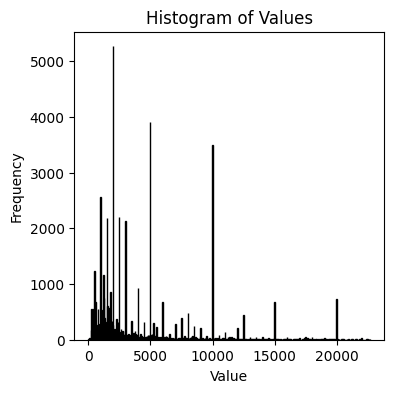

In [152]:
#Re-plot hist to ensure outliers are removed
plt.figure(figsize=(4, 4))  # Optional: specify the figure size
df1['Value'].plot(kind='hist', bins=500, edgecolor='black')

plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [ ]:
#Only consider donations from the last 3 elections so that we do not skew recency values, i.e. consider values from 2015-2019 only. 
# Convert start_date and end_date to datetime format
start_date = pd.to_datetime('2010-05-06') #2010 election date
end_date = pd.to_datetime('2019-12-12')   #2019 election date


# Filter the DataFrame based on date range
df1 = df1[(df1['ReceivedDate'] >= start_date) & (df1['ReceivedDate'] <= end_date)]

# RFM ANALYSIS 

In [153]:
#Compute recency values
recency_df = df1.groupby(by='DonorId', as_index=False)['ReceivedDate'].max()
recency_df.columns = ['DonorId', 'LastPurchaseDate']
recent_date = recency_df['LastPurchaseDate'].max()
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
recency_df.head

<bound method NDFrame.head of        DonorId LastPurchaseDate  Recency
0          1.0       2001-05-14     6685
1          2.0       2003-08-11     5866
2          3.0       2015-02-18     1657
3          4.0       2010-12-31     3167
4          5.0       2009-12-15     3548
...        ...              ...      ...
38291  87465.0       2019-08-01       32
38292  87467.0       2019-07-22       42
38293  87473.0       2019-08-05       28
38294  87478.0       2018-11-01      305
38295  87479.0       2009-12-29     3534

[38296 rows x 3 columns]>

In [154]:
#Compute Frequency 
frequency_df = df1.drop_duplicates().groupby(
    by=['DonorId'], as_index=False)['ReceivedDate'].count()
frequency_df.columns = ['DonorId', 'Frequency']
frequency_df.head

<bound method NDFrame.head of        DonorId  Frequency
0          1.0          1
1          2.0          1
2          3.0          3
3          4.0          9
4          5.0          3
...        ...        ...
38291  87465.0          1
38292  87467.0          1
38293  87473.0          1
38294  87478.0          2
38295  87479.0          1

[38296 rows x 2 columns]>

In [155]:
#Compute Monetary Value
monetary_df = df1.groupby(by='DonorId', as_index=False)['Value'].sum()
monetary_df.columns = ['DonorId', 'Monetary']
monetary_df.head

<bound method NDFrame.head of        DonorId  Monetary
0          1.0   3000.00
1          2.0   6148.88
2          3.0  26625.00
3          4.0  34495.89
4          5.0   7700.00
...        ...       ...
38291  87465.0  10000.00
38292  87467.0  10000.00
38293  87473.0   4000.00
38294  87478.0   3529.41
38295  87479.0  11520.00

[38296 rows x 2 columns]>

In [156]:
#merge R, F & M values into one df
rfm = pd.merge(recency_df, frequency_df, on='DonorId')
rfm = pd.merge(rfm, monetary_df, on='DonorId')

In [157]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]
frequency_scores = [1, 2, 3, 4, 5]
monetary_scores = [1, 2, 3, 4, 5]
recency_weight = 1
frequency_weight = 1
monetary_weight = 1

In [158]:
# Calculate RFM scores
rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=len(recency_scores), labels=recency_scores)
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=len(frequency_scores), labels=frequency_scores)
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=len(monetary_scores), labels=monetary_scores)
# Convert RFM scores to numeric type
rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']] = rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].astype(int)

In [159]:
#Calculate RFM score
rfm['RFM_Score'] = recency_weight*rfm['RecencyScore'] + frequency_weight*rfm['FrequencyScore'] + monetary_weight*rfm['MonetaryScore']

#Segment donors based on score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
rfm['RFM_Segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)

In [160]:
# Create a new column for RFM Customer Segments
rfm['RFM_Customer_Segment'] = ''
# Assign RFM segments based on the RFM score
rfm.loc[rfm['RFM_Score'] >= 9, 'RFM_Customer_Segment'] = 'Champions'
rfm.loc[(rfm['RFM_Score'] >= 6) & (rfm['RFM_Score'] < 9), 'RFM_Customer_Segment'] = 'Potential Loyalists'
rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 6), 'RFM_Customer_Segment'] = 'At Risk Customers'
rfm.loc[(rfm['RFM_Score'] >= 4) & (rfm['RFM_Score'] < 5), 'RFM_Customer_Segment'] = "Can't Lose"
rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 4), 'RFM_Customer_Segment'] = "Lost"

In [161]:
rfm

,DonorId,LastPurchaseDate,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFM_Segment,RFM_Customer_Segment
0,1.0,2001-05-14,6685,1,3000.00,1,1,1,3,Low-Value,Lost
1,2.0,2003-08-11,5866,1,6148.88,1,1,1,3,Low-Value,Lost
2,3.0,2015-02-18,1657,3,26625.00,4,1,1,6,High-Value,Potential Loyalists
3,4.0,2010-12-31,3167,9,34495.89,3,1,1,5,Mid-Value,At Risk Customers
4,5.0,2009-12-15,3548,3,7700.00,3,1,1,5,Mid-Value,At Risk Customers
...,...,...,...,...,...,...,...,...,...,...,...
38291,87465.0,2019-08-01,32,1,10000.00,5,1,1,7,High-Value,Potential Loyalists
38292,87467.0,2019-07-22,42,1,10000.00,5,1,1,7,High-Value,Potential Loyalists
38293,87473.0,2019-08-05,28,1,4000.00,5,1,1,7,High-Value,Potential Loyalists
38294,87478.0,2018-11-01,305,2,3529.41,5,1,1,7,High-Value,Potential Loyalists


In [162]:
#export data to output file
rfm.to_csv('output/output.csv', index=False)